In [28]:
# This is for accessing my google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# This code is for TPU usage in Colab 
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.4.1
Running on TPU  ['10.65.47.2:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.65.47.2:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.65.47.2:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [3]:
import os
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Dropout
from tensorflow.keras.layers import Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from skimage.metrics import structural_similarity as ssim
import math 

In [4]:
# check the number of data (high quality scans) and sort them
output = next(os.walk("/content/drive/My Drive/reduced_vs_thin_Al/Z 2/"))[2] 
print("No. of data = ", len(output))
output.sort()

No. of data =  1000


In [5]:
# High Quality Images 
folder = '/content/drive/My Drive/reduced_vs_thin_Al/Z 2'
high_quality = np.zeros(shape=(2000, 512, 512), dtype='uint16')

In [6]:
# import high quality images from the folder and take 2 random patches from each of them
for filename, i in zip(output, tqdm(range(1000))):
        im = Image.open(os.path.join(folder, filename))
        img = np.array(im)
        high_quality[i] = img[1000:1512, 1000:1512]
        high_quality[i + 1000] = img[1500:2012, 1500:2012]

100%|█████████▉| 999/1000 [14:26<00:00,  1.01it/s]

In [7]:
# check the number of data (low quality scans)
inputs = next(os.walk("/content/drive/My Drive/reduced_vs_thin_Al/Z 3"))[2] 
print("No. of data = ", len(inputs))
inputs.sort()  

No. of data =  1000


In [8]:
# Low Quality Images
folder = '/content/drive/My Drive/reduced_vs_thin_Al/Z 3'
low_quality = np.zeros(shape=(2000, 512, 512), dtype='uint16')

In [ ]:
# import low quality images from the folder and take 2 random patches from each of them
for filename, i in zip(inputs, tqdm(range(1000))):
        im = Image.open(os.path.join(folder, filename))
        img = np.array(im)
        low_quality[i] = img[1000:1512, 1000:1512]
        low_quality[i + 1000] = img[1500:2012, 1500:2012]

173


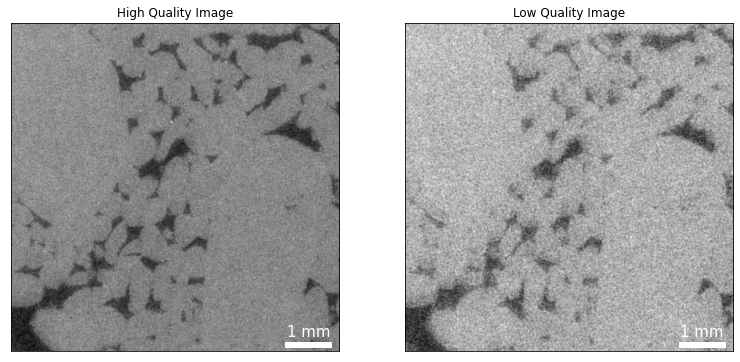

In [10]:
# Visualize a random pair from the training set (low_quality vs high quality)
ix = random.randint(0, len(high_quality))
print(ix)
plt.figure(figsize=(20,10))
plt.subplot(1,3,1), 
plt.title('High Quality Image')
plt.imshow(high_quality[ix], cmap='gray', extent=(0, 7.168, 0, 7.168))
plt.fill_between(x=[6.0, 7.0], y1=[0.1, 0.1], y2=[0.2, 0.2], color='white')
plt.text(x=6.50, y=0.25, s='1 mm', va='bottom', ha='center', color='white', size=15)
plt.xticks([]), plt.yticks([])
plt.subplot(1,3,2)
plt.title('Low Quality Image')
plt.imshow(low_quality[ix], cmap='gray', extent=(0, 7.168, 0, 7.168))
plt.fill_between(x=[6.0, 7.0], y1=[0.1, 0.1], y2=[0.2, 0.2], color='white')
plt.text(x=6.50, y=0.25, s='1 mm', va='bottom', ha='center', color='white', size=15)
plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
low_quality = cv2.convertScaleAbs(low_quality, alpha=(255.0/65535.0))

In [ ]:
high_quality = cv2.convertScaleAbs(high_quality, alpha=(255.0/65535.0))

In [11]:
# normalization of the labels (high_quality images)
high_quality= high_quality / 65535
#min_value = np.min(high_quality)
#max_value = np.max(high_quality)
#high_quality = (high_quality - min_value) / (max_value-min_value) 
#high_quality = high_quality.astype('float64')
#for i in range(len(high_quality)):
  #high_quality[i] = (high_quality[i] - np.min(high_quality[i])) / (np.max(high_quality[i]) - np.min(high_quality[i]))
#high_quality = high_quality.astype('float64')
#for i in range(len(high_quality)):
  #high_quality[i] = (high_quality[i] - np.mean(high_quality[i])) / (np.std(high_quality[i]))

#high_quality = (high_quality - np.mean(high_quality)) / np.std(high_quality)



In [14]:
# normalization of the inputs(low_quality images)
low_quality = low_quality / 65535
#min_value = np.min(low_quality)
#max_value = np.max(low_quality)
#low_quality = (low_quality - min_value) / (max_value-min_value) 
#low_quality = low_quality.astype('float64')
#for i in range(len(low_quality)):
  #low_quality[i] = (low_quality[i] - np.min(low_quality[i])) / (np.max(low_quality[i]) - np.min(low_quality[i]))
#low_quality = low_quality.astype('float64')
#for i in range(len(low_quality)):
  #low_quality[i] = (low_quality[i] - np.mean(low_quality[i])) / (np.std(low_quality[i]))
#low_quality = (low_quality - np.mean(low_quality)) / np.std(low_quality)

In [15]:
# Add the channel dimension before training
high_quality = high_quality.reshape(-1, 512, 512, 1 )
low_quality = low_quality.reshape(-1, 512, 512, 1)

In [16]:
# split the data into test and training according to the ratio of 20/80.
input_images_train, input_images_test, output_images_train, output_images_test = train_test_split(low_quality, high_quality, test_size=0.2, random_state=42)

In [17]:
initializer = 'he_normal'

In [18]:
def cnn(input_img):

  # Encoder Stage

  c1 = Conv2D(filters=32, kernel_size=(3, 3), \
               kernel_initializer= initializer , strides=(1,1), padding='same')(input_img)
  c1 = Activation('relu')(c1)

  c2 = Conv2D(filters=32, kernel_size=(3, 3), \
               kernel_initializer= initializer , strides=(1,1), padding='same')(c1)
  c2 = Activation('relu')(c2)

  #c3 = Conv2D(filters=32, kernel_size=(3, 3), \
               #kernel_initializer='he_uniform', strides=(1,1), padding='same')(c2)
  #c3 = Activation('relu')(c3)



  p1 = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid')(c2)
  
  
  c4 = Conv2D(filters=64, kernel_size=(3, 3), \
               kernel_initializer=initializer , strides=(1,1), padding='same')(p1)
  c4 = Activation('relu')(c4)
  
  c5 = Conv2D(filters=64, kernel_size=(3, 3), \
               kernel_initializer=initializer , strides=(1,1), padding='same')(c4)
  c5 = Activation('relu')(c5)

  #c6 = Conv2D(filters=64, kernel_size=(3, 3), \
               #kernel_initializer='he_uniform', strides=(1,1), padding='same')(c5)
  #c6 = Activation('relu')(c6)


  
  p2 = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid')(c5)
  
  
  
  
  
  c7 = Conv2D(filters=128, kernel_size=(3, 3), \
               kernel_initializer=initializer , strides=(1,1), padding='same')(p2)
  c7 = Activation('relu')(c7)
  
  c8 = Conv2D(filters=128, kernel_size=(3, 3), \
               kernel_initializer=initializer , strides=(1,1), padding='same')(c7)
  c8 = Activation('relu')(c8)  

  #c9 = Conv2D(filters=128, kernel_size=(3, 3), \
               #kernel_initializer='he_uniform', strides=(1,1), padding='same')(c8)
  #c9 = Activation('relu')(c9) 


  
  
  
  p3 = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid')(c8)





  c10 = Conv2D(filters=256, kernel_size=(3, 3), \
               kernel_initializer=initializer , strides=(1,1), padding='same')(p3)
  c11 = Activation('relu')(c10)

  c12 = Conv2D(filters=256, kernel_size=(3, 3), \
               kernel_initializer=initializer , strides=(1,1), padding='same')(c11)
  c12 = Activation('relu')(c12) 

  #c13 = Conv2D(filters=256, kernel_size=(3, 3), \
               #kernel_initializer='he_uniform', strides=(1,1), padding='same')(c12)
  #c13 = Activation('relu')(c13) 

  d1 = Dropout(0.3)(c12)

  # Decoder Stage

  t1 = Conv2DTranspose(filters=128,kernel_size=(3,3), strides=(2, 2), padding='same')(d1)
  t1 = Activation('relu')(t1)
  concat_1 = concatenate([t1,c8])
  c14 = Conv2D(filters=128, kernel_size=(3, 3), \
               kernel_initializer=initializer , strides=(1,1), padding='same')(concat_1)
  c14 = Activation('relu')(c14)
  c15 = Conv2D(filters=128, kernel_size=(3, 3), \
               kernel_initializer=initializer , strides=(1,1), padding='same')(c14)
  c15 = Activation('relu')(c15)
  #c15 = Conv2D(filters=128, kernel_size=(3, 3), \
               #kernel_initializer='he_uniform', strides=(1,1), padding='same')(c15)
  #c15 = Activation('relu')(c15)


  t2 =  Conv2DTranspose(filters=64,kernel_size=(2,2), strides=(2, 2), padding='same')(c15)
  t2 = Activation('relu')(t2)
  concat_2 = concatenate([t2,c5])
  c16 = Conv2D(filters=64, kernel_size=(3, 3), \
               kernel_initializer=initializer , strides=(1,1), padding='same')(concat_2)
  c16 = Activation('relu')(c16)
  c17 = Conv2D(filters=64, kernel_size=(3, 3), \
               kernel_initializer=initializer , strides=(1,1), padding='same')(c16)
  c17 = Activation('relu')(c17)
  #c18 = Conv2D(filters=64, kernel_size=(3, 3), \
               #kernel_initializer='he_uniform', strides=(1,1), padding='same')(c17)
  #c18 = Activation('relu')(c18)



  t3 = Conv2DTranspose(filters=32,kernel_size=(2,2), strides=(2, 2), padding='same')(c17)
  t3 = Activation('relu')(t3)
  concat_3 = concatenate([t3,c2])
  c19 = Conv2D(filters=32, kernel_size=(3, 3), \
               kernel_initializer=initializer , strides=(1,1), padding='same')(concat_3)
  c19 = Activation('relu')(c19)
  c20 = Conv2D(filters=32, kernel_size=(3, 3), \
               kernel_initializer=initializer , strides=(1,1), padding='same')(c19)
  c20 = Activation('relu')(c20)
  #c21 = Conv2D(filters=32, kernel_size=(3, 3), \
               #kernel_initializer='he_uniform', strides=(1,1), padding='same')(c20)
  #c21 = Activation('relu')(c21)





  outputs = Conv2D(filters=1, kernel_size=(1, 1), \
               kernel_initializer=initializer , strides=(1,1), padding='same')(c20)
  model = Model(inputs=[input_img], outputs=[outputs])
  return model

In [19]:
# compile model and determine the loss function
with tpu_strategy.scope():

  input_img = Input((512, 512, 1)) 
  model = cnn(input_img)


  model.compile(optimizer=Adam(), loss='mean_squared_error')
  #model.compile(optimizer=Adam(learning_rate=0.0001), loss=custom_loss)

  model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 512, 512, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 32) 9248        activation[0][0]                 
______________________________________________________________________________________________

In [20]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)
] 

In [21]:
training_results = model.fit(input_images_train, output_images_train, batch_size=16, epochs=50,callbacks=callbacks,\
                             validation_data=(input_images_test, output_images_test)) 

Epoch 1/50
100/100 [==============================] - 45s 321ms/step - loss: 0.0051 - val_loss: 2.6891e-05
Epoch 2/50
100/100 [==============================] - 16s 156ms/step - loss: 2.5843e-05 - val_loss: 2.6489e-05
Epoch 3/50
100/100 [==============================] - 16s 156ms/step - loss: 2.5464e-05 - val_loss: 2.5085e-05
Epoch 4/50
100/100 [==============================] - 16s 155ms/step - loss: 2.3715e-05 - val_loss: 2.3378e-05
Epoch 5/50
100/100 [==============================] - 16s 156ms/step - loss: 2.2884e-05 - val_loss: 2.4248e-05
Epoch 6/50
100/100 [==============================] - 16s 156ms/step - loss: 2.3020e-05 - val_loss: 2.3681e-05

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 7/50
100/100 [==============================] - 16s 157ms/step - loss: 2.2415e-05 - val_loss: 2.2554e-05
Epoch 8/50
100/100 [==============================] - 16s 156ms/step - loss: 2.1874e-05 - val_loss: 2.2549e-05
Epoch 9/50
100/100 [==============

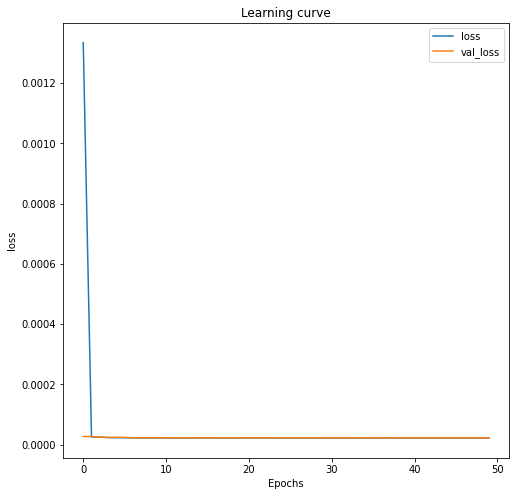

In [22]:
# Plot the learning curve
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(training_results.history["loss"], label="loss")
plt.plot(training_results.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend();

In [23]:
# Prediction
prediction = model.predict(input_images_test, verbose=1) 

13/13 [==============================] - 20s 2s/step


In [26]:
# random image from the test set
ix = random.randint(0, len(input_images_test))
print(ix)

276


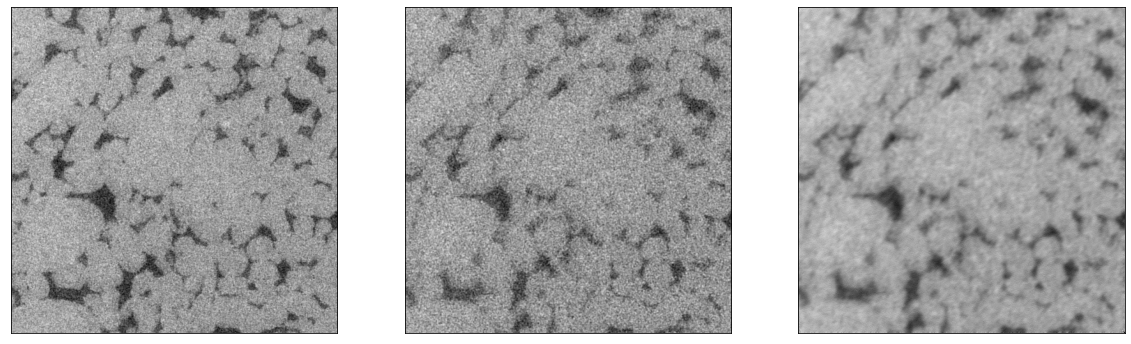

In [27]:
# Visualize any random test image along with the label and prediction
plt.figure(figsize=(20,6))
plt.subplot(1,3,1), 
plt.imshow(output_images_test[ix][:,:,0], cmap='gray'), 
#plt.title('High Quality Image')
plt.xticks([]), plt.yticks([])
plt.subplot(1,3,2),
plt.imshow(input_images_test[ix][:,:,0], cmap='gray'),
#plt.title('Reduced Time Exposure \n SSIM:%5.2f PSNR:%5.2f'%(S1,p1))
plt.xticks([]), plt.yticks([])
plt.subplot(1,3,3),
plt.imshow(prediction[ix][:,:,0], cmap='gray'),
#plt.title('Prediction \n SSIM:%5.2f PSNR:%5.2f'%(S2,p2))
plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
hq = (output_images_test[ix][:,:,0] - np.min(output_images_test[ix][:,:,0])) / (np.max(output_images_test[ix][:,:,0]) - np.min(output_images_test[ix][:,:,0]))
lq = (input_images_test[ix][:,:,0] - np.min(input_images_test[ix][:,:,0])) / (np.max(input_images_test[ix][:,:,0]) - np.min(input_images_test[ix][:,:,0]))
denoised = (prediction[ix][:,:,0] - np.min(prediction[ix][:,:,0])) / (np.max(prediction[ix][:,:,0]) - np.min(prediction[ix][:,:,0]))


In [ ]:
from skimage.util import img_as_ubyte
img_as_ubyte(hq)
img_as_ubyte(lq)

array([[122, 122, 143, ..., 187, 187, 208],
       [100,  88, 118, ..., 160, 169, 207],
       [130, 120, 147, ..., 152, 140, 169],
       ...,
       [166, 181, 192, ..., 192, 207, 212],
       [160, 170, 169, ..., 188, 206, 200],
       [158, 148, 154, ..., 172, 175, 186]], dtype=uint8)

In [114]:
# SSIM (Structural Similarity Index)
S1 = ssim(output_images_test[ix][:,:,0], input_images_test[ix][:,:,0], data_range=1,gaussian_weights=True,sigma=1.5, use_sample_covariance=False)
S2 = ssim(output_images_test[ix][:,:,0], prediction[ix][:,:,0], data_range=1,gaussian_weights=True,sigma=1.5, use_sample_covariance=False)
print('SSIM between the high_quality and low_quality image:%.5f'%(S1))
print('SSIM between the high_quality and denoised image:%.5f'%(S2)) 

SSIM between the high_quality and low_quality image:0.51932
SSIM between the high_quality and denoised image:0.76266


In [60]:
# PSNR (Peak Signal-to-Noise Ratio)
# The PSNR computes the peak signal-to-noise ratio, in decibels, between two images.
def psnr(img1, img2):
  mse = np.mean( (img1 - img2) ** 2 ) # calculate mean squared error between two images
  return 10 * math.log10(1 / mse) 

In [115]:
p1 = psnr(output_images_test[ix][:,:,0],  input_images_test[ix][:,:,0])
p2 = psnr(output_images_test[ix][:,:,0], prediction[ix][:,:,0])

print('PSNR between the high_quality and low_quality image:%.5f'%(p1))
print('PSNR between the high_quality and denoised image:%.5f'%(p2))

PSNR between the high_quality and low_quality image:22.50128
PSNR between the high_quality and denoised image:33.89236
